# Transfer Learning for Jet Tagging in Particle Physics: GNN

This is the second accompanying notebook for our final project for the CSCI 2470: Deep Learning course. Here, we will present appropriate visualizations of our input data, build and train our models, and present appropriate visualizations of the outputs and results.

*Authors: Jade Ducharme, Egor Serebriakov, Aditya Singh, Anthony Wong*

### Stage 2: Transfer Learning via GNN

The current state-of-the-art jet tagging model uses a Graph Neural Network architecture. Our second goal is then to build a Teacher and a Student GNN and implement transfer learning similarly to what we did with the FCCN.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchmetrics
import torch.optim as optim
from torch_geometric.loader import DataLoader
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import time
from preprocess import *
from helper import *
from visualize import *

sns.set_theme()
plt.style.use("seaborn-v0_8")

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# Initialize some global hyperparameters

K = 16  # number of neighbors for the KNN
NE = 20  # number of epochs
LR = 3e-4  # learning rate
WEIGHT_DECAY = 1e-5  # weight decay for L2 regularization
BATCH_SZ = 384  # batch size
MAX_ITEMS = 150000  # maximum number of elements to consider (input size)
MAX_CONSTITS = 80  # maximum number of constituent elements per jet: 80
REDUCED_CONSTITS = 80  # number of constituent elements for the Student network to consider: 40
NOISE_STD = 1e4  # noise standard deviation for the diffusion
ALPHA = 0.8  # alpha parameter for knowledge transfer: 0.8
TEMP = 2.0  # temperature parameter for knowledge transfer: 2.0

Similarly to the first notebook, we will start by loading in the data and preprocessing. Note that since we are now working with *graphs*, the preprocessing steps will differ significantly!

In [3]:
cons_data, cons_labels, cons_weights, cons_features = get_data(
    "./data/train.h5", 
    attribute="constituents",
    max_items=MAX_ITEMS,
)

print("---------- Constituent-level data ----------------", "\n")
print("Data shape [input_size, num_constituents, num_features]:", cons_data.shape, "\n")
print("Feature names:", cons_features)
print("Feature names (human-readable):", [human_feature(f) for f in cons_features])

---------- Constituent-level data ---------------- 

Data shape [input_size, num_constituents, num_features]: (150000, 200, 4) 

Feature names: ['fjet_clus_E' 'fjet_clus_eta' 'fjet_clus_phi' 'fjet_clus_pt']
Feature names (human-readable): ['constituent energy', 'constituent pseudo-rapidity', 'constituent azimuthal angle', 'constituent transverse momentum']


We will preprocess this using the same steps as for the FCNN

In [4]:
pre_cons_data, pre_cons_features = constituent_preprocess(cons_data, cons_features, max_constits=MAX_CONSTITS)

print("Preprocessed constituent data shape:", pre_cons_data.shape)
print("Preprocessed features:", pre_cons_features)

/oscar/data/jpober/jmduchar/DL-Final-Project/preprocess.py:145: RuntimeWarning: divide by zero encountered in log
  log_pt = np.log(pt)
/oscar/data/jpober/jmduchar/DL-Final-Project/preprocess.py:146: RuntimeWarning: divide by zero encountered in log
  log_energy = np.log(energy)
/oscar/data/jpober/jmduchar/DL-Final-Project/preprocess.py:153: RuntimeWarning: divide by zero encountered in log
  lognorm_pt = np.log(pt / sum_pt[:,np.newaxis])
/oscar/data/jpober/jmduchar/DL-Final-Project/preprocess.py:154: RuntimeWarning: divide by zero encountered in log
  lognorm_energy = np.log(energy / sum_energy[:,np.newaxis])


Preprocessed constituent data shape: (150000, 80, 7)
Preprocessed features: ['delta_eta' 'delta_phi' 'log_pt' 'log_E' 'lognorm_pt' 'lognorm_E' 'R']


To implement our GNN, we then need to form graphs using our data. We will do so using the k-nearest-neighbors algorithm, and we will try to run on GPU to accelerate the graph making process.

In [5]:
# Check for CUDA, then default to CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

graphs = prepare_graphs(pre_cons_data, cons_labels, k=K, weights=cons_weights, device=device, batch_size=BATCH_SZ)

Device: cuda


/users/jmduchar/anaconda/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|█████████████████████████████████████████| 391/391 [01:57<00:00,  3.33it/s]


#### Visualize

We can visualize the graphs we just created!

In [6]:
# visualize_graph(graphs[100], x_axis='fjet_clus_phi', y_axis='fjet_clus_eta')

#### Build the Teacher GNN

Let's build the Teacher GNN and train it on the high-resolution data:

In [7]:
from model import run_model, train_with_distillation


def training_loop(model, device, graphs, plot_confusion=False, teacher_model=None, alpha=ALPHA, temp=TEMP):
    """
    Run the whole training loop on the model given data, labels, and weights

    References a lot of global parameters
    """
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss(reduction='none')  
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    # Data preparation
    train_set, val_set, test_set = split_graphs(graphs, 0.7, 0.15)

    train_loader = DataLoader(train_set, batch_size=BATCH_SZ, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SZ, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=BATCH_SZ, shuffle=True)

    loss_list, acc_list = [], []
    val_loss_list, val_acc_list = [], []

    t0 = time.time()
    for epoch in range(1,NE+1):

        # training -- with knowledge distillation
        if teacher_model:
            loss, acc = train_with_distillation(model, teacher_model, "gnn",
                                                train_loader, criterion, optimizer, 
                                                device, alpha=alpha, temperature=temp)
            
        # training -- without knowledge distillation
        else:
            loss, acc = run_model(model, "gnn", device, train_loader, criterion, optimizer=optimizer, train=True)

        loss_list.append(loss)
        acc_list.append(acc)

        # validation
        val_loss, val_acc, _, _ = run_model(model, "gnn", device, val_loader, criterion, train=False)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        if epoch%5 == 0:
            print(f"E {epoch:02d} -- Train loss: {loss:.3f} -- Train acc: {acc:.3f} -- "\
                + f"Val loss: {val_loss:.3f} -- Val acc: {val_acc:.3f} -- t elapsed: {time_elapsed(t0,time.time())} mins"
        )
            
    # Testing on unseen data...
    test_loss, test_acc, fpr, tpr = run_model(
        model, "gnn", device, test_loader, criterion, train=False,
        )
    

    # And finally plot the confusion matrix if desired
    if plot_confusion:

        true = []
        pred = []
        for d, l, w in test_set:
            d = d.unsqueeze(0)
            true.append(l.item())
            p = np.argmax(model(d.to(device)).cpu().detach().numpy())
            pred.append(p)

        plot_confusion_matrices(true, pred, "")
            
    return loss_list, acc_list, val_loss_list, val_acc_list, test_loss, test_acc, fpr, tpr

In [8]:
from model import JetGNN
from preprocess import split_graphs

# initialize model
teacher_gnn = JetGNN().to(device)

# Train and test the model
unpackable1 = training_loop(teacher_gnn, device, graphs)

# Unpack results
teach_trainloss, teach_trainacc, teach_valloss, teach_valacc, teach_testloss, teach_testacc, fpr_teacher, tpr_teacher = unpackable1

E 05 -- Train loss: 0.360 -- Train acc: 0.841 -- Val loss: 0.376 -- Val acc: 0.851 -- t elapsed: 4.42 mins
E 10 -- Train loss: 0.322 -- Train acc: 0.859 -- Val loss: 0.378 -- Val acc: 0.824 -- t elapsed: 8.85 mins
E 15 -- Train loss: 0.281 -- Train acc: 0.876 -- Val loss: 0.395 -- Val acc: 0.830 -- t elapsed: 13.23 mins
E 20 -- Train loss: 0.237 -- Train acc: 0.894 -- Val loss: 0.440 -- Val acc: 0.829 -- t elapsed: 17.59 mins


Teacher GNN trained on high-quality data


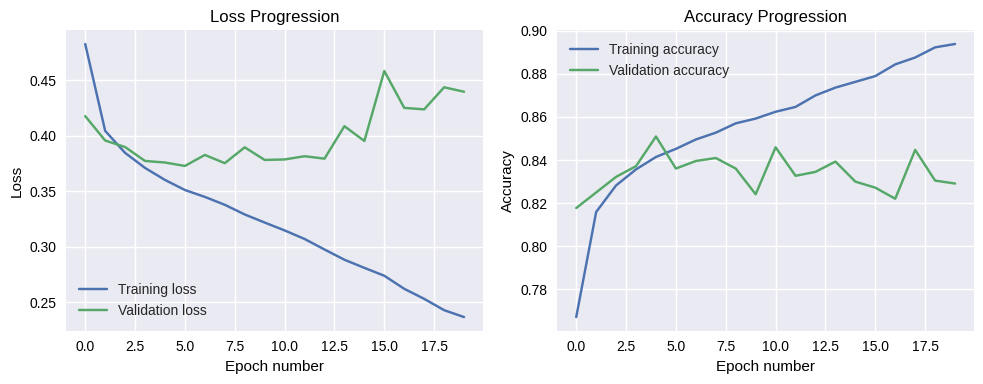

Final test loss: 0.4403	 Final test acc: 0.8344


In [9]:
print("Teacher GNN trained on high-quality data")

plot_loss_and_accuracy(teach_trainloss, teach_valloss, teach_trainacc, teach_valacc, 
                       # transparent=True,
                       # save_path="./teacher_fcnn.png",
                       )

print(f"Final test loss: {teach_testloss:.4f}\t Final test acc: {teach_testacc:.4f}")

#### Diffusion

Next, we diffuse the input data along the energy column, padd back to the original number of constituents, and recreate the graphs

In [10]:
from helper import diffuse

diffused_cons_data = diffuse(cons_data, cons_features, noise_std=NOISE_STD, 
                             apply_features=['fjet_clus_E', 'fjet_clus_pt'],
                            )

diff_pre_cons_data, _ = constituent_preprocess(diffused_cons_data, cons_features, max_constits=REDUCED_CONSTITS)
padded_data = add_constits(diff_pre_cons_data, target_shape=MAX_CONSTITS)

reduced_graphs = prepare_graphs(padded_data, cons_labels, k=K, weights=cons_weights, device=device, batch_size=BATCH_SZ)

/oscar/data/jpober/jmduchar/DL-Final-Project/preprocess.py:145: RuntimeWarning: divide by zero encountered in log
  log_pt = np.log(pt)
/oscar/data/jpober/jmduchar/DL-Final-Project/preprocess.py:145: RuntimeWarning: invalid value encountered in log
  log_pt = np.log(pt)
/oscar/data/jpober/jmduchar/DL-Final-Project/preprocess.py:146: RuntimeWarning: divide by zero encountered in log
  log_energy = np.log(energy)
/oscar/data/jpober/jmduchar/DL-Final-Project/preprocess.py:146: RuntimeWarning: invalid value encountered in log
  log_energy = np.log(energy)
/oscar/data/jpober/jmduchar/DL-Final-Project/preprocess.py:153: RuntimeWarning: divide by zero encountered in log
  lognorm_pt = np.log(pt / sum_pt[:,np.newaxis])
/oscar/data/jpober/jmduchar/DL-Final-Project/preprocess.py:153: RuntimeWarning: invalid value encountered in log
  lognorm_pt = np.log(pt / sum_pt[:,np.newaxis])
/oscar/data/jpober/jmduchar/DL-Final-Project/preprocess.py:154: RuntimeWarning: divide by zero encountered in log
  l

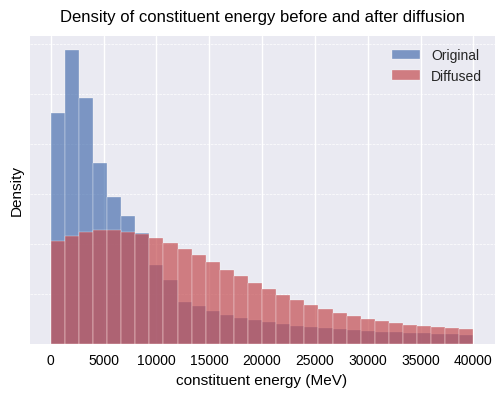

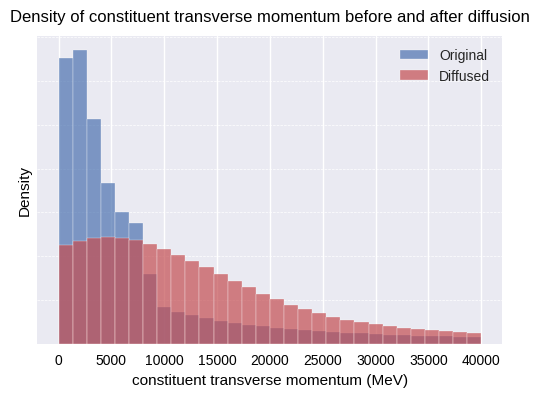

In [11]:
plot_diffused_histogram(cons_data, diffused_cons_data, cons_features, plot_feature='fjet_clus_E', xrange=[0,4e4],
                        transparent=False, 
                        save_path="./gnn_diffusion_E.png",
                        )

plot_diffused_histogram(cons_data, diffused_cons_data, cons_features, plot_feature='fjet_clus_pt', xrange=[0,4e4],
                        transparent=False, 
                        save_path="./gnn_diffusion_pt.png",
                        )

### Student model - no distillation

In [12]:
# initialize model
student_no_distill = JetGNN().to(device)

# Run the training loop
unpackable2 = training_loop(student_no_distill, device, reduced_graphs)

# Unpack the results
stu_trainloss, stu_trainacc, stu_valloss, stu_valacc, stu_testloss, stu_testacc, fpr_student, tpr_student = unpackable2

E 05 -- Train loss: 0.404 -- Train acc: 0.818 -- Val loss: 0.424 -- Val acc: 0.802 -- t elapsed: 4.42 mins
E 10 -- Train loss: 0.374 -- Train acc: 0.835 -- Val loss: 0.415 -- Val acc: 0.811 -- t elapsed: 8.85 mins
E 15 -- Train loss: 0.354 -- Train acc: 0.842 -- Val loss: 0.422 -- Val acc: 0.807 -- t elapsed: 13.23 mins
E 20 -- Train loss: 0.323 -- Train acc: 0.854 -- Val loss: 0.468 -- Val acc: 0.801 -- t elapsed: 17.61 mins


Student GNN trained on low-quality data without knowledge distillation


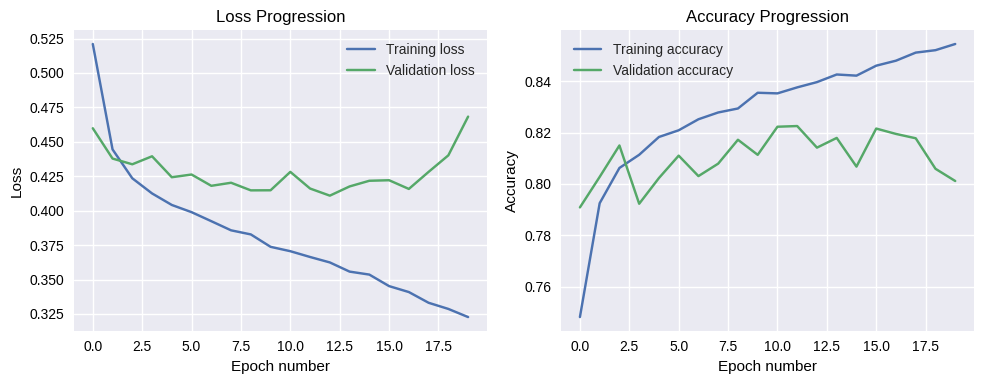

Final test loss: 0.4484	 Final test acc: 0.8045


In [13]:
print("Student GNN trained on low-quality data without knowledge distillation")

plot_loss_and_accuracy(stu_trainloss, stu_valloss, stu_trainacc, stu_valacc,
                       # transparent=True,
                       # save_path="./student_fcnn_nodistill.png",
                       )
print(f"Final test loss: {stu_testloss:.4f}\t Final test acc: {stu_testacc:.4f}")

### Transfer Learning from the Teacher to the Student GNN

In [14]:
# initialize model
student_gnn = JetGNN().to(device)

# run the training loop
unpackable3 = training_loop(student_gnn, device, reduced_graphs, teacher_model=teacher_gnn)

# unpack results
dist_trainloss, dist_trainacc, dist_valloss, dist_valacc, dist_testloss, dist_testacc, fpr_distill, tpr_distill = unpackable3

/users/jmduchar/anaconda/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


E 05 -- Train loss: 0.435 -- Train acc: 0.784 -- Val loss: 0.447 -- Val acc: 0.747 -- t elapsed: 5.82 mins
E 10 -- Train loss: 0.418 -- Train acc: 0.800 -- Val loss: 0.434 -- Val acc: 0.802 -- t elapsed: 11.64 mins
E 15 -- Train loss: 0.404 -- Train acc: 0.811 -- Val loss: 0.430 -- Val acc: 0.788 -- t elapsed: 17.47 mins
E 20 -- Train loss: 0.391 -- Train acc: 0.820 -- Val loss: 0.435 -- Val acc: 0.801 -- t elapsed: 23.28 mins


Student GNN trained on low-quality data with knowledge distillation


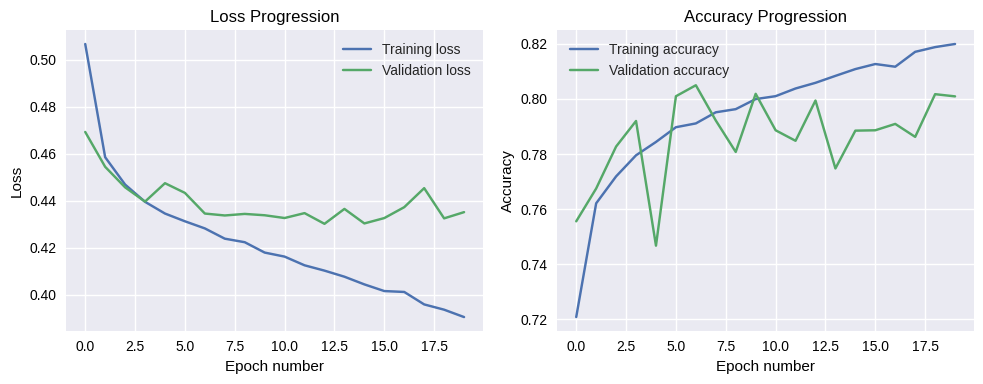

Final test loss: 0.4412	 Final test acc: 0.8024


In [15]:
print("Student GNN trained on low-quality data with knowledge distillation")

plot_loss_and_accuracy(dist_trainloss, dist_valloss, dist_trainacc, dist_valacc,
                       # transparent=True,
                       # save_path="./student_fcnn_withdistill.png",
                       )

print(f"Final test loss: {dist_testloss:.4f}\t Final test acc: {dist_testacc:.4f}")

Condense our results into one ROC Curve plot

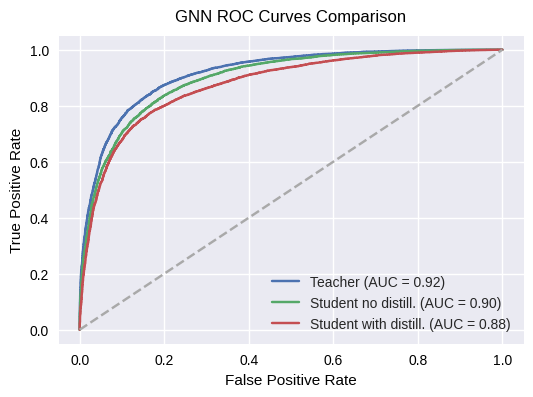

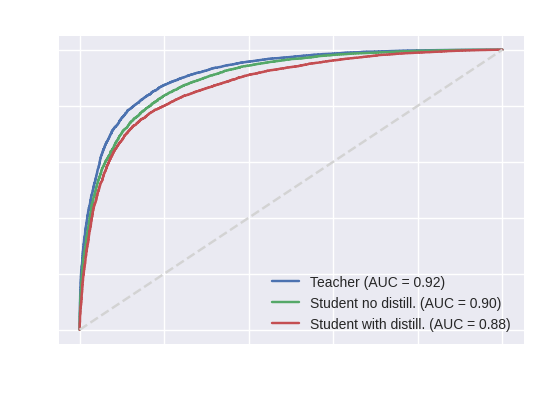

In [16]:
plot_roc(fpr_teacher, tpr_teacher, fpr_student, tpr_student, fpr_distill, tpr_distill, model_name="GNN",
         transparent=False,
         save_path="./GNN_ROC_diffusion.png"
         )

plot_roc(fpr_teacher, tpr_teacher, fpr_student, tpr_student, fpr_distill, tpr_distill, model_name="GNN",
         transparent=True,
         save_path="./GNN_ROC_diffusion_transparent.png"
         )

In [17]:
# Check out what hardware we're running on
!nvidia-smi

Sat May  4 00:38:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX               On  | 00000000:61:00.0 Off |                  N/A |
| 53%   67C    P2             105W / 280W |   8550MiB / 24576MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
# Note: good performance and speed with NVIDIA TITAN RTX